In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# dir = '../Dataset Statistics/dataset'
dir = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Dataset Statistics/dataset'

train_df = pd.read_csv(f'{dir}/train.csv')
val_df = pd.read_csv(f'{dir}/val.csv')
test_df = pd.read_csv(f'{dir}/test.csv')

X_train, y_train, X_val, y_val, X_test, y_test = train_df['text'].values, train_df['class'].values, val_df['text'].values, val_df['class'].values, test_df['text'].values, test_df['class'].values

In [4]:
import re
from nltk.corpus import stopwords
import string
import nltk

nltk.download('stopwords')

def preprocess_text(text):
    # Replace @user with ''
    text = re.sub(r'@user', '', text)
    # Remove #tags
    text = re.sub(r'#(\w+)', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords

    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    # Join the words back into a string
    text = ' '.join(filtered_words)
    return text.strip()

X_train = [preprocess_text(text) for text in X_train]
X_val = [preprocess_text(text) for text in X_val]
X_test = [preprocess_text(text) for text in X_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import random

num = random.randint(0, len(X_train) - 1)
print('Text:', train_df['text'][num])
print('\nPreprocessed Text:', X_train[num])

Text: #happy #monday! no #need or #reason to #feel   or #cry ever #again. #god has #fulfilled his #promise to us #all! have and #awesome day!

Preprocessed Text: ever us day


#### Exploratory Data Analysis (EDA)

In [6]:
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

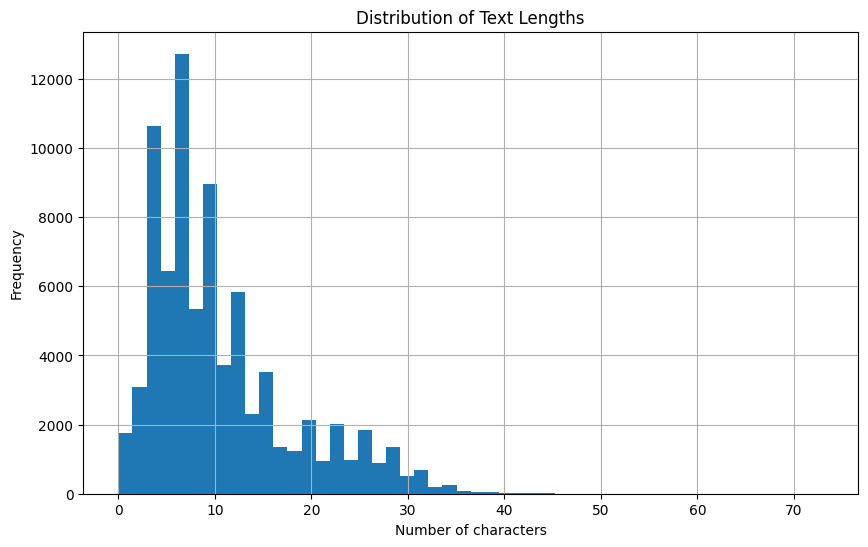

In [7]:
import matplotlib.pyplot as plt

temp = train_df.copy()
temp['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
temp['text_length'].hist(bins=50)
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [8]:
import numpy as np

percentiles = np.percentile(temp['text_length'], [50, 75, 90, 95, 99])
print(percentiles)

[ 8. 14. 23. 27. 32.]


In [9]:
from collections import Counter
import nltk

nltk.download('punkt')
all_words = [word for review in temp['text'] for word in nltk.word_tokenize(review)]
word_freq = Counter(all_words)
print(f"Total unique words: {len(word_freq)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total unique words: 102101


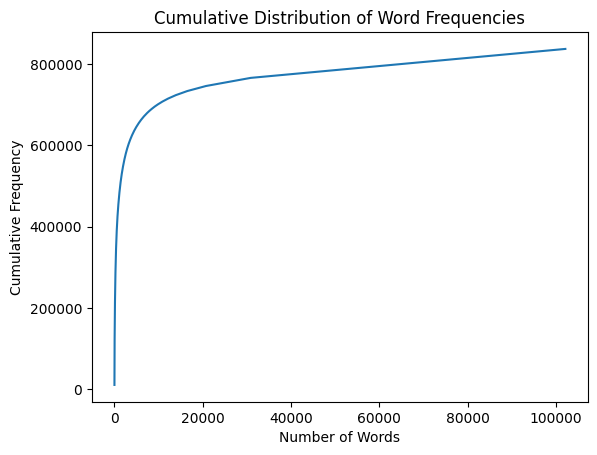

In [10]:
word_counts = list(word_freq.values())
word_counts.sort(reverse=True)
cumulative_counts = np.cumsum(word_counts)

plt.plot(cumulative_counts)
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Distribution of Word Frequencies')
plt.show()

In [11]:
max_features = 700000
max_len = 30

tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [12]:
# glove_path = 'resources/glove.6B.100d.txt'
glove_path = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/resources/glove.6B.100d.txt'
embedding_dim = 100

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index:
            idx = word_index[word]
            embedding_matrix[idx] = np.array(values[1:], dtype='float32')

In [13]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           10210400  
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10295009 (39.27 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 10210400 (38.95 MB)
_________________________________________________________________


In [14]:
model.input_shape, model.output_shape

((None, 30), (None, 1))

In [15]:
X_train_padded.shape, y_train.shape

((78989, 30), (78989,))

In [16]:
# import tensorflow as tf

# tf.config.run_functions_eagerly(True)

model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_test), epochs=10, batch_size=4096)

Epoch 1/10
20/20 [==============================] - 14s 227ms/step - loss: 0.5266 - accuracy: 0.7732 - val_loss: 1.0328 - val_accuracy: 0.5469
Epoch 2/10
20/20 [==============================] - 6s 302ms/step - loss: 0.2530 - accuracy: 0.8977 - val_loss: 1.8595 - val_accuracy: 0.5340
Epoch 3/10
20/20 [==============================] - 4s 179ms/step - loss: 0.1574 - accuracy: 0.9431 - val_loss: 1.9689 - val_accuracy: 0.5324
Epoch 4/10
20/20 [==============================] - 4s 180ms/step - loss: 0.1222 - accuracy: 0.9580 - val_loss: 2.1777 - val_accuracy: 0.5326
Epoch 5/10
20/20 [==============================] - 5s 256ms/step - loss: 0.1053 - accuracy: 0.9647 - val_loss: 2.2691 - val_accuracy: 0.5322
Epoch 6/10
20/20 [==============================] - 4s 214ms/step - loss: 0.0934 - accuracy: 0.9691 - val_loss: 2.3863 - val_accuracy: 0.5330
Epoch 7/10
20/20 [==============================] - 4s 183ms/step - loss: 0.0822 - accuracy: 0.9732 - val_loss: 2.4412 - val_accuracy: 0.5325
Epoch

In [17]:
import pickle

path = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/saved_models/lstm_10_epcohs.pkl'
with open(path, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle

path = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/saved_models/lstm_10_epcohs.pkl'
with open(path, 'rb') as f:
    model = pickle.load(f)

In [18]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy:.2f}')

823/823 [==============================] - 18s 22ms/step - loss: 0.0615 - accuracy: 0.9818
Loss: 0.06152639910578728, Accuracy: 0.98


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test_padded)
y_pred = [1 if num > 0.5 else 0 for num in y_pred]

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

823/823 [==============================] - 18s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16076
           1       0.98      0.98      0.98     10254

    accuracy                           0.98     26330
   macro avg       0.98      0.98      0.98     26330
weighted avg       0.98      0.98      0.98     26330



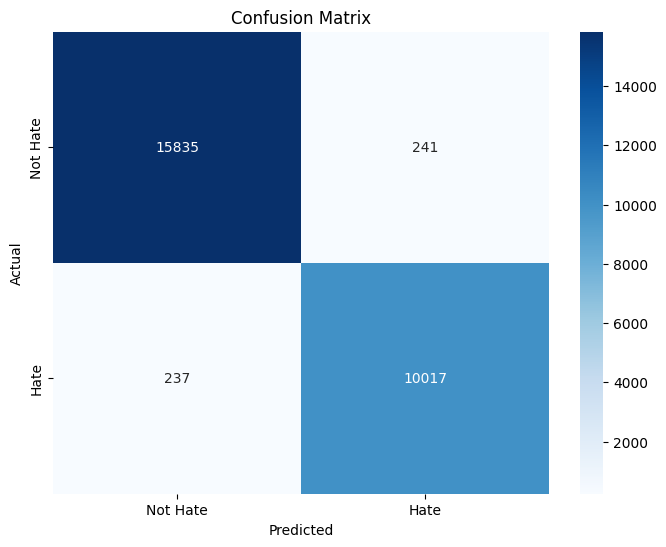

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
def predict(text, threshold=0.5):
    text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text])
    seq_pad = pad_sequences(seq, maxlen=max_len)
    prediction = model.predict(seq_pad)[0]
    class_label = 1 if prediction >= threshold else 0
    confidence = prediction if class_label == 1 else 1 - prediction

    return class_label, confidence

text_to_predict = "This is the sort of thing that happens in a shithole country. @URL"
predicted_class, confidence = predict(text_to_predict)

if predicted_class == 1:
    print(f'Predicted class: Hate Speech \nConfidence: {confidence[0]:.2f}')
else:
    print(f'Predicted class: Not Hate Speech \nConfidence: {confidence[0]:.2f}')

1/1 [==============================] - 0s 56ms/step
Predicted class: Not Hate Speech 
Confidence: 0.66
